# Stroke Prediction and Anaysis Using Machine Learning

## Introduction

In this notebook, we will describe step-by-step procedure for building a machine learning (ML) model for stroke prediction and analysing which features are most useful for the prediction. The packages used in this notebook are as follows:
- Python (v3.7)
- Pandas (v1.0.3)
- Numpy (v1.18.1)
- Matplotlib (v3.2.1)
- Scikit-Learn (v0.22.1)
- Imbalanced-Learn (v0.6.2)
- LightGBM (v2.3.1)
- XGBoost (v1.0.2)

## Data Exploration and Visualisation

We will use the [Kaggle stroke dataset](https://www.kaggle.com/asaumya/healthcare-dataset-stroke-data) (train_2v.csv) comprising 12 columns (variables) as listed in the following table.

| No  | Variable          | Definition                                           |        
| --- | ---               | ---                                                  |
| 1   | id                | Patient ID                                           |
| 2   | gender            | Gender of patient                                    |
| 3   | age               | Age of patient                                       |
| 4   | hypertension      | 0: no hypertension, 1: suffering from hypertension   |
| 5   | heart_disease     | 0: no heart disease, 1: suffering from heart disease |
| 6   | ever_married      | Yes/No                                               |
| 7   | work_type         | Type of occupation                                   |
| 8   | Residence_type    | Area type of residence (urban/rural)                 |
| 9   | avg_glucose_level | Average glucose level (measured after meal)          |
| 10  | bmi               | Body mass index                                      |
| 11  | smoking_status    | Patient's smoking status                             |
| 12  | stroke            | 0: no stroke, 1: suffered stroke                     |

### Importing all the relevant packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
from sklearn.metrics import auc,roc_auc_score,roc_curve,precision_score,recall_score,f1_score
import time as timer
from sklearn.inspection import permutation_importance

### Opening the dataset
It is important to understand the dataset before going deeper into the subsequent process. Here, we will explore the information about the dataset, such as number of samples, presence of missing values, class imbalance, etc.

In [ ]:
# import package
# open dataset
filename = "train_strokes.csv"
data = pd.read_csv(filename)
with pd.option_context('expand_frame_repr', False):
    print(data.head())
print("Data shape: {}".format(data.shape))

In [ ]:
data.describe()

As shown above, the number of rows (samples) is 43400 and number of columns (variables) is 12. There are some missing values (indicated by NaN). Now, we want to check how many missing values exist in each variable.

In [ ]:
miss_val = data.isnull().sum()/len(data)*100
print(miss_val)
print("# Missing values in variable bmi\t\t: {:.2f}%".format(miss_val['bmi']))
print("# Missing values in variable smoking_status\t: {:.2f}%".format(miss_val['smoking_status']))
print("Data shape: {}".format(data.shape))

There are two variables that contain missing values. First, 'bmi' that accounts for 3.37% of overal samples; second, 'smoking_status' that accounts for 30.63% of overall samples. To handle these missing values, we will remove the samples from all the variables associated with the indices of missing values in 'smoking_status'. For missing values in 'bmi' variable, we will replace them with the average of 'bmi' values.

### Handling Missing Values

In [ ]:
# Safely disable new warning with the chained assignment.
pd.options.mode.chained_assignment = None  # default='warn'
# replace missing values in variable 'bmi' with its mean
data['bmi']=data['bmi'].fillna(data['bmi'].mean())
# remove (drop) data associated with missing values in variable 'smoking_status'
clean_data = data[data['smoking_status'].notnull()]
# drop variable 'id'
clean_data.drop(columns='id',axis=1,inplace=True)
# validate there's no more missing values
miss_val = clean_data.isnull().sum()/len(clean_data)*100
print(miss_val)
print("# Missing values in variable 'bmi'\t\t: {}".format(miss_val['bmi']))
print("# Missing values in variable 'smoking_status'\t: {}".format(miss_val['smoking_status']))
print("Shape of data without missing values: {}".format(clean_data.shape))

### Changing Category to Numerical Values

Since some variables are categorical, we have to convert them into numerical variables.

In [ ]:
print("Unique 'gender': {}".format(clean_data['gender'].unique()))
print("Unique 'ever_married': {}".format(clean_data['ever_married'].unique()))
print("Unique 'work_type': {}".format(clean_data['work_type'].unique()))
print("Unique 'Residence_type': {}".format(clean_data['Residence_type'].unique()))
print("Unique 'smoking_status': {}".format(clean_data['smoking_status'].unique()))

In [ ]:
# create encoder for each categorical variable
label_gender = LabelEncoder()
label_married = LabelEncoder()
label_work = LabelEncoder()
label_residence = LabelEncoder()
label_smoking = LabelEncoder()

In [ ]:
clean_data['gender'] = label_gender.fit_transform(clean_data['gender'])
clean_data['ever_married'] = label_married.fit_transform(clean_data['ever_married'])
clean_data['work_type']= label_work.fit_transform(clean_data['work_type'])
clean_data['Residence_type']= label_residence.fit_transform(clean_data['Residence_type'])
clean_data['smoking_status']= label_smoking.fit_transform(clean_data['smoking_status'])
with pd.option_context('expand_frame_repr', False):
    print(clean_data.head())

### Inter-feature Correlation

It is sometimes useful to measure the inter-feature correlation. If we find that a feature is highly correlated with the class (target), it could be an indication that this feature is informative about the class. In addition, if a feature is highly correlated with other features, we could remove one of them thus reducing the complexity while potentially improving the model's learning.

In [ ]:
fig, ax = plt.subplots(figsize=(8,6))
im = ax.matshow(clean_data.corr())
ax.set_xticks(np.arange(clean_data.shape[1]))
ax.set_yticks(np.arange(clean_data.shape[1]))
ax.set_xticklabels(clean_data.columns,rotation=90)
ax.set_yticklabels(clean_data.columns)
# Create colorbar
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("Correlation", rotation=-90, va="bottom", fontsize=12)
fig.tight_layout()
plt.show()

### Histogram of Features

In [ ]:
fig = clean_data.hist(figsize=(10,8))
plt.tight_layout()
plt.show()

### Class (Target) Distribution
Now, let's take a look at the distribution of class (target). If the class is highly imbalanced, we have to solve this issue so that our model will not be biased towards the majority class.

In [ ]:
class_occur = clean_data['stroke'].value_counts()
class_names = ['No Stroke','Stroke']
fig, ax = plt.subplots()
ax.pie(class_occur, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=0, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_occur[0]))
print("# samples associated with stroke: {}".format(class_occur[1]))

## Data Preprocessing

### Handle Imbalanced Class

There are several techniques that can be used to handle highly imbalanced class. This [article](https://heartbeat.fritz.ai/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa) nicely summarises those different techniques. In this notebook, we are going to use one of oversampling technique called Synthetic Minority Oversampling Technique (SMOTE), by synthesising new samples from the minority class to have the same number of samples as the majority class (illustrated in figure below). Oversampling technique is chosen because we do not want to loose significant amount of information (97.88%) as if we use undersampling technique.
<figure>
 <img src="https://miro.medium.com/max/1400/1*o_KfyMzF7LITK2DlYm_wHw.png" style="width: 400px;" alt=""/>
 <figcaption>
 Source: <a href="https://heartbeat.fritz.ai/resampling-to-properly-handle-imbalanced-datasets-in-machine-learning-64d82c16ceaa">here</a>
 </figcaption>
</figure>

In [ ]:
# create the  object with the desired sampling strategy.
ada = ADASYN(sampling_strategy='minority')

# fit the object to our training data
X, y = ada.fit_resample(clean_data.loc[:,clean_data.columns!='stroke'], clean_data['stroke'])
print("Shape of X: {}".format(X.shape))
print("Shape of y: {}".format(y.shape))

# New section

In [ ]:
_, class_counts = np.unique(y, return_counts=True)
class_names = ['No stroke', 'Stroke']
fig, ax = plt.subplots()
ax.pie(class_counts, labels=class_names, autopct='%1.2f%%',
        shadow=True, startangle=90, counterclock=False)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax.set_title('Class distribution')
plt.show()
print("# samples associated with no stroke: {}".format(class_counts[0]))
print("# samples associated with stroke: {}".format(class_counts[1]))

In [ ]:
from sklearn.model_selection import cross_val_score


### Data Splitting

In [ ]:
def split_train_valid_test(X,y,test_size=0.1,random_state=None):
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size, random_state=random_state, stratify=y)
    X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train,test_size=test_size/(1-test_size), random_state=random_state, stratify=y_train)
    return X_train, X_valid, X_test, y_train, y_valid, y_test

X_train, X_valid, X_test, y_train, y_valid, y_test = split_train_valid_test(X,y,test_size=0.1,random_state=42)
_, train_counts = np.unique(y_train, return_counts=True)
_, valid_counts = np.unique(y_valid, return_counts=True)
_, test_counts = np.unique(y_test, return_counts=True)
print("[train] # class 0: {} | # class 1: {}".format(train_counts[0],train_counts[1]))
print("[valid] # class 0: {} | # class 1: {}".format(valid_counts[0],valid_counts[1]))
print("[test]  # class 0: {} | # class 1: {}".format(test_counts[0],test_counts[1]))

### Data Normalisation

In [ ]:
scaler = StandardScaler()
scaler = scaler.fit(X_train)

X_train_std = scaler.transform(X_train)
X_valid_std = scaler.transform(X_valid)
X_test_std = scaler.transform(X_test)

## ML Model Training and Evaluation
We will implement and benchmark the performance of the following 7 ML algorithms:
1. Singular Vector Machine (SVM)
2. Gaussian Naive Bayes (GNB)
3. Logistic Regression (LR)
4. Decision Tree (DT)
5. Random Forest (RF)
6. LightGBM (LGBM)
7. XGboost (XGB)

### Performance Metrics

The peformance will be evaluated based on two different groups of metrics:
1. Sensitivity, specificity, and area under the curve (AUC)
2. Precision, recall, and F1 score

In [ ]:
def calc_sens_spec(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true,y_pred)
    TP = conf_matrix[1][1]
    TN = conf_matrix[0][0]
    FP = conf_matrix[0][1]
    FN = conf_matrix[1][0]
    # calculate the sensitivity
    sensitivity = TP / (TP + FN)    
    # calculate the specificity
    specificity = TN / (TN + FP)
    return sensitivity,specificity

### Singular Vector Machine (SVM)

In [ ]:
start = timer.time()
svm_model = SVC(kernel='rbf',probability=True)
svm_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_svm = svm_model.predict(X_test_std)
y_svm_prob = svm_model.predict_proba(X_test_std)

Finished training within 405.01 seconds


Classification report for SVM: 
              precision    recall  f1-score   support

           0       0.88      0.80      0.83      2947
           1       0.81      0.89      0.85      2952

    accuracy                           0.84      5899
   macro avg       0.85      0.84      0.84      5899
weighted avg       0.85      0.84      0.84      5899

Confusion matrix for SVM: 
[[2344  603]
 [ 328 2624]]
Accuracy score for SVM: 0.84
Precision score for SVM: 0.81
Recall score for SVM: 0.89
F1 score for SVM: 0.85
Sensitivity score for SVM: 0.89
Specitivity score for SVM: 0.80
AUC score for SVM: 0.92


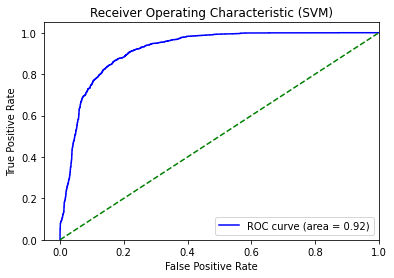

In [ ]:
print("Classification report for SVM: \n{}".format(classification_report(y_test,y_svm)))
print("Confusion matrix for SVM: \n{}".format(confusion_matrix(y_test,y_svm)))
print("Accuracy score for SVM: {:.2f}".format(accuracy_score(y_test,y_svm)))
# calculate precision, recall, and f1 scores
prec_svm = precision_score(y_test,y_svm)
rec_svm = recall_score(y_test,y_svm)
f1_svm = f1_score(y_test,y_svm)
print("Precision score for SVM: {:.2f}".format(prec_svm))
print("Recall score for SVM: {:.2f}".format(rec_svm))
print("F1 score for SVM: {:.2f}".format(f1_svm))
# calculate sensitivity, specificity, and auc
sens_svm,spec_svm = calc_sens_spec(y_test,y_svm)
fpr, tpr, _ = roc_curve(y_test,  y_svm_prob[:,1])
auc_svm = roc_auc_score(y_test, y_svm_prob[:,1])
print("Sensitivity score for SVM: {:.2f}".format(sens_svm))
print("Specitivity score for SVM: {:.2f}".format(spec_svm))
print("AUC score for SVM: {:.2f}".format(auc_svm))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_svm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (SVM)')
ax.legend(loc="lower right")
plt.show()

### Gaussian Naive Bayes (GNB)

In [ ]:
start = timer.time()
gnb_model = GaussianNB()
gnb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_gnb = gnb_model.predict(X_test_std)
y_gnb_prob = gnb_model.predict_proba(X_test_std)

Finished training within 0.03 seconds


Classification report for GNB: 
              precision    recall  f1-score   support

           0       0.80      0.73      0.76      2947
           1       0.75      0.82      0.78      2952

    accuracy                           0.77      5899
   macro avg       0.78      0.77      0.77      5899
weighted avg       0.78      0.77      0.77      5899

Confusion matrix for GNB: 
[[2137  810]
 [ 524 2428]]
Accuracy score for GNB: 0.77
Precision score for GNB: 0.75
Recall score for GNB: 0.82
F1 score for GNB: 0.78
Sensitivity score for GNB: 0.82
Specitivity score for GNB: 0.73
AUC score for GNB: 0.85


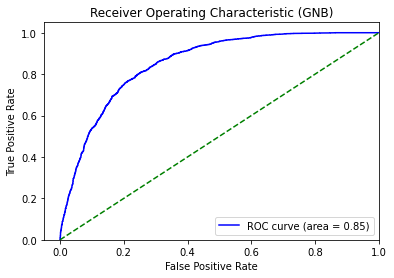

In [ ]:
print("Classification report for GNB: \n{}".format(classification_report(y_test,y_gnb)))
print("Confusion matrix for GNB: \n{}".format(confusion_matrix(y_test,y_gnb)))
print("Accuracy score for GNB: {:.2f}".format(accuracy_score(y_test,y_gnb)))
# calculate precision, recall, and f1 scores
prec_gnb = precision_score(y_test,y_gnb)
rec_gnb = recall_score(y_test,y_gnb)
f1_gnb = f1_score(y_test,y_gnb)
print("Precision score for GNB: {:.2f}".format(prec_gnb))
print("Recall score for GNB: {:.2f}".format(rec_gnb))
print("F1 score for GNB: {:.2f}".format(f1_gnb))
# calculate sensitivity, specificity, and auc
sens_gnb,spec_gnb = calc_sens_spec(y_test,y_gnb)
fpr, tpr, _ = roc_curve(y_test,  y_gnb_prob[:,1])
auc_gnb = roc_auc_score(y_test, y_gnb_prob[:,1])
print("Sensitivity score for GNB: {:.2f}".format(sens_gnb))
print("Specitivity score for GNB: {:.2f}".format(spec_gnb))
print("AUC score for GNB: {:.2f}".format(auc_gnb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_gnb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (GNB)')
ax.legend(loc="lower right")
plt.show()

### Logistic Regression (LR)

In [ ]:
start = timer.time()
logit_model = LogisticRegression(solver='lbfgs', random_state=42)
logit_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_logit = logit_model.predict(X_test_std)
y_logit_prob = logit_model.predict_proba(X_test_std)

Finished training within 0.10 seconds


Classification report for LR: 
              precision    recall  f1-score   support

           0       0.80      0.76      0.78      2947
           1       0.77      0.81      0.79      2952

    accuracy                           0.78      5899
   macro avg       0.78      0.78      0.78      5899
weighted avg       0.78      0.78      0.78      5899

Confusion matrix for LR: 
[[2230  717]
 [ 563 2389]]
Accuracy score for LR: 0.78
Precision score for LR: 0.77
Recall score for LR: 0.81
F1 score for LR: 0.79
Sensitivity score for LR: 0.81
Specitivity score for LR: 0.76
AUC score for LR: 0.87


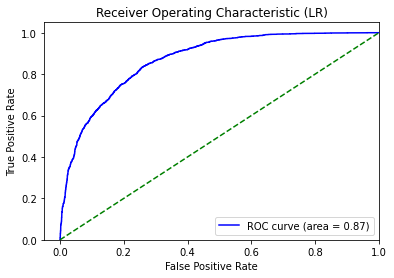

In [ ]:
print("Classification report for LR: \n{}".format(classification_report(y_test,y_logit)))
print("Confusion matrix for LR: \n{}".format(confusion_matrix(y_test,y_logit)))
print("Accuracy score for LR: {:.2f}".format(accuracy_score(y_test,y_logit)))
# calculate precision, recall, and f1 scores
prec_logit = precision_score(y_test,y_logit)
rec_logit = recall_score(y_test,y_logit)
f1_logit = f1_score(y_test,y_logit)
print("Precision score for LR: {:.2f}".format(prec_logit))
print("Recall score for LR: {:.2f}".format(rec_logit))
print("F1 score for LR: {:.2f}".format(f1_logit))
# calculate sensitivity, specificity, and auc
sens_logit,spec_logit = calc_sens_spec(y_test,y_logit)
fpr, tpr, _ = roc_curve(y_test,  y_logit_prob[:,1])
auc_logit = roc_auc_score(y_test, y_logit_prob[:,1])
print("Sensitivity score for LR: {:.2f}".format(sens_logit))
print("Specitivity score for LR: {:.2f}".format(spec_logit))
print("AUC score for LR: {:.2f}".format(auc_logit))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_logit)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LR)')
ax.legend(loc="lower right")
plt.show()

### Decision Tree (DT)

In [ ]:
start = timer.time()
dtree_model = DecisionTreeClassifier(random_state=42)
dtree_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_dtree = dtree_model.predict(X_test_std)
y_dtree_prob = dtree_model.predict_proba(X_test_std)

Finished training within 0.29 seconds


Classification report for DT: 
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      2947
           1       0.93      0.96      0.95      2952

    accuracy                           0.94      5899
   macro avg       0.95      0.94      0.94      5899
weighted avg       0.95      0.94      0.94      5899

Confusion matrix for DT: 
[[2745  202]
 [ 123 2829]]
Accuracy score for DT: 0.94
Precision score for DT: 0.93
Recall score for DT: 0.96
F1 score for DT: 0.95
Sensitivity score for DT: 0.96
Specitivity score for DT: 0.93
AUC score for DT: 0.94


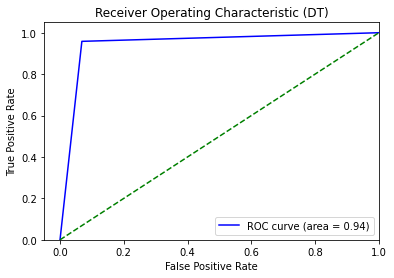

In [ ]:
print("Classification report for DT: \n{}".format(classification_report(y_test,y_dtree)))
print("Confusion matrix for DT: \n{}".format(confusion_matrix(y_test,y_dtree)))
print("Accuracy score for DT: {:.2f}".format(accuracy_score(y_test,y_dtree)))
# calculate precision, recall, and f1 scores
prec_dtree = precision_score(y_test,y_dtree)
rec_dtree = recall_score(y_test,y_dtree)
f1_dtree = f1_score(y_test,y_dtree)
print("Precision score for DT: {:.2f}".format(prec_dtree))
print("Recall score for DT: {:.2f}".format(rec_dtree))
print("F1 score for DT: {:.2f}".format(f1_dtree))
# calculate sensitivity, specificity, and auc
sens_dtree,spec_dtree = calc_sens_spec(y_test,y_dtree)
fpr, tpr, _ = roc_curve(y_test,  y_dtree_prob[:,1])
auc_dtree = roc_auc_score(y_test, y_dtree_prob[:,1])
print("Sensitivity score for DT: {:.2f}".format(sens_dtree))
print("Specitivity score for DT: {:.2f}".format(spec_dtree))
print("AUC score for DT: {:.2f}".format(auc_dtree))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_dtree)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (DT)')
ax.legend(loc="lower right")
plt.show()

### Random Forest (RF)

In [ ]:
start = timer.time()
ranfor_model = RandomForestClassifier(n_estimators=100, random_state=42)
ranfor_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_ranfor = ranfor_model.predict(X_test_std)
y_ranfor_prob = ranfor_model.predict_proba(X_test_std)

Classification report for RF: 
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      2947
           1       0.96      0.98      0.97      2952

    accuracy                           0.97      5899
   macro avg       0.97      0.97      0.97      5899
weighted avg       0.97      0.97      0.97      5899

Confusion matrix for RF: 
[[2817  130]
 [  68 2884]]
Accuracy score for RF: 0.97
Precision score for RF: 0.96
Recall score for RF: 0.98
F1 score for RF: 0.97
Sensitivity score for RF: 0.98
Specitivity score for RF: 0.96
AUC score for RF: 1.00


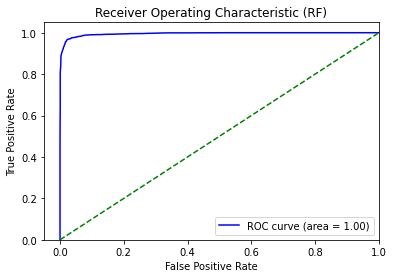

In [ ]:
print("Classification report for RF: \n{}".format(classification_report(y_test,y_ranfor)))
print("Confusion matrix for RF: \n{}".format(confusion_matrix(y_test,y_ranfor)))
print("Accuracy score for RF: {:.2f}".format(accuracy_score(y_test,y_ranfor)))
# calculate precision, recall, and f1 scores
prec_ranfor = precision_score(y_test,y_ranfor)
rec_ranfor = recall_score(y_test,y_ranfor)
f1_ranfor = f1_score(y_test,y_ranfor)
print("Precision score for RF: {:.2f}".format(prec_ranfor))
print("Recall score for RF: {:.2f}".format(rec_ranfor))
print("F1 score for RF: {:.2f}".format(f1_ranfor))
# calculate sensitivity, specificity, and auc
sens_ranfor,spec_ranfor = calc_sens_spec(y_test,y_ranfor)
fpr, tpr, _ = roc_curve(y_test,  y_ranfor_prob[:,1])
auc_ranfor = roc_auc_score(y_test, y_ranfor_prob[:,1])
print("Sensitivity score for RF: {:.2f}".format(sens_ranfor))
print("Specitivity score for RF: {:.2f}".format(spec_ranfor))
print("AUC score for RF: {:.2f}".format(auc_ranfor))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_ranfor)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (RF)')
ax.legend(loc="lower right")
plt.show()

### LightGBM (LGBM)

In [ ]:
start = timer.time()
lgbm_model = LGBMClassifier(n_estimators=100, random_state=42)
lgbm_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_lgbm = lgbm_model.predict(X_test_std)
y_lgbm_prob = lgbm_model.predict_proba(X_test_std)

Finished training within 0.60 seconds


Classification report for LGBM: 
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      2947
           1       0.93      0.94      0.94      2952

    accuracy                           0.93      5899
   macro avg       0.94      0.93      0.93      5899
weighted avg       0.94      0.93      0.93      5899

Confusion matrix for LGBM: 
[[2730  217]
 [ 167 2785]]
Accuracy score for LGBM: 0.93
Precision score for LGBM: 0.93
Recall score for LGBM: 0.94
F1 score for LGBM: 0.94
Sensitivity score for LGBM: 0.94
Specitivity score for LGBM: 0.93
AUC score for LGBM: 0.99


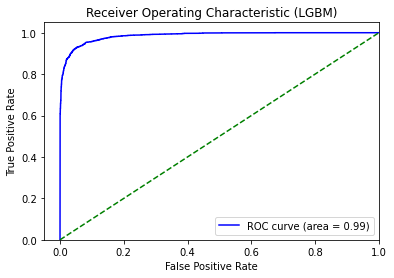

In [ ]:
print("Classification report for LGBM: \n{}".format(classification_report(y_test,y_lgbm)))
print("Confusion matrix for LGBM: \n{}".format(confusion_matrix(y_test,y_lgbm)))
print("Accuracy score for LGBM: {:.2f}".format(accuracy_score(y_test,y_lgbm)))
# calculate precision, recall, and f1 scores
prec_lgbm = precision_score(y_test,y_lgbm)
rec_lgbm = recall_score(y_test,y_lgbm)
f1_lgbm = f1_score(y_test,y_lgbm)
print("Precision score for LGBM: {:.2f}".format(prec_lgbm))
print("Recall score for LGBM: {:.2f}".format(rec_lgbm))
print("F1 score for LGBM: {:.2f}".format(f1_lgbm))
# calculate sensitivity, specificity, and auc
sens_lgbm,spec_lgbm = calc_sens_spec(y_test,y_lgbm)
fpr, tpr, _ = roc_curve(y_test,  y_lgbm_prob[:,1])
auc_lgbm = roc_auc_score(y_test, y_lgbm_prob[:,1])
print("Sensitivity score for LGBM: {:.2f}".format(sens_lgbm))
print("Specitivity score for LGBM: {:.2f}".format(spec_lgbm))
print("AUC score for LGBM: {:.2f}".format(auc_lgbm))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_lgbm)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (LGBM)')
ax.legend(loc="lower right")
plt.show()

### XGBoost (XGB)

In [ ]:
start = timer.time()
xgb_model = XGBClassifier(objective="binary:logistic", random_state=42)
xgb_model.fit(X_train_std, y_train)
end = timer.time()
print("Finished training within {:.2f} seconds".format(end-start))
# Predicting the test set results
y_xgb = xgb_model.predict(X_test_std)
y_xgb_prob = xgb_model.predict_proba(X_test_std)

Finished training within 2.57 seconds


Classification report for XGB: 
              precision    recall  f1-score   support

           0       0.88      0.80      0.84      2947
           1       0.82      0.89      0.85      2952

    accuracy                           0.85      5899
   macro avg       0.85      0.85      0.85      5899
weighted avg       0.85      0.85      0.85      5899

Confusion matrix for XGB: 
[[2360  587]
 [ 322 2630]]
Accuracy score for XGB: 0.85
Precision score for XGB: 0.82
Recall score for XGB: 0.89
F1 score for XGB: 0.85
Sensitivity score for XGB: 0.89
Specitivity score for XGB: 0.80
AUC score for XGB: 0.93


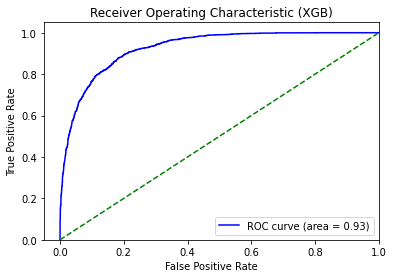

In [ ]:
print("Classification report for XGB: \n{}".format(classification_report(y_test,y_xgb)))
print("Confusion matrix for XGB: \n{}".format(confusion_matrix(y_test,y_xgb)))
print("Accuracy score for XGB: {:.2f}".format(accuracy_score(y_test,y_xgb)))
# calculate precision, recall, and f1 scores
prec_xgb = precision_score(y_test,y_xgb)
rec_xgb = recall_score(y_test,y_xgb)
f1_xgb = f1_score(y_test,y_xgb)
print("Precision score for XGB: {:.2f}".format(prec_xgb))
print("Recall score for XGB: {:.2f}".format(rec_xgb))
print("F1 score for XGB: {:.2f}".format(f1_xgb))
# calculate sensitivity, specificity, and auc
sens_xgb,spec_xgb = calc_sens_spec(y_test,y_xgb)
fpr, tpr, _ = roc_curve(y_test,  y_xgb_prob[:,1])
auc_xgb = roc_auc_score(y_test, y_xgb_prob[:,1])
print("Sensitivity score for XGB: {:.2f}".format(sens_xgb))
print("Specitivity score for XGB: {:.2f}".format(spec_xgb))
print("AUC score for XGB: {:.2f}".format(auc_xgb))
fig, ax = plt.subplots()
ax.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % auc_xgb)
ax.plot([0, 1], [0, 1], color='green', linestyle='--')
ax.set_xlim([-0.05, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver Operating Characteristic (XGB)')
ax.legend(loc="lower right")
plt.show()

## Performance Benchmark Across Models

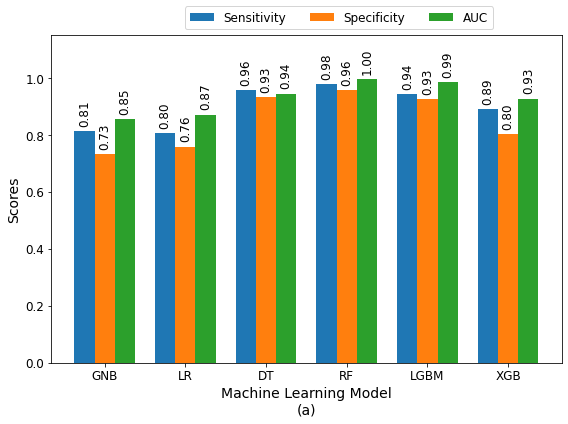

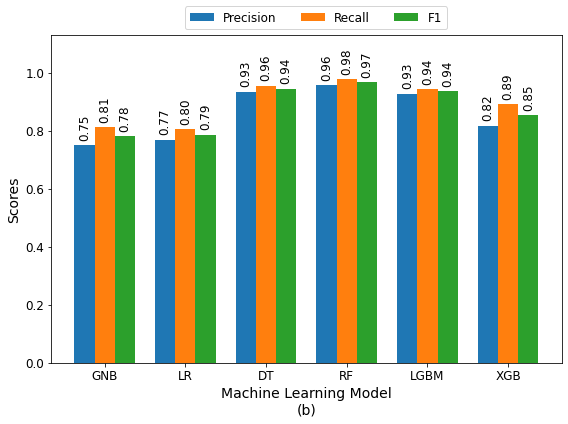

In [ ]:
ml_names = ['GNB', 'LR', 'DT', 'RF', 'LGBM', 'XGB']
sens_all = [sens_gnb, sens_logit, sens_dtree, sens_ranfor, sens_lgbm, sens_xgb]
spec_all = [spec_gnb, spec_logit, spec_dtree, spec_ranfor, spec_lgbm, spec_xgb]
auc_all = [auc_gnb, auc_logit, auc_dtree, auc_ranfor, auc_lgbm, auc_xgb]

prec_all = [prec_gnb, prec_logit, prec_dtree, prec_ranfor, prec_lgbm, prec_xgb]
rec_all = [rec_gnb, rec_logit, rec_dtree, rec_ranfor, rec_lgbm, rec_xgb]
f1_all = [f1_gnb, f1_logit, f1_dtree, f1_ranfor, f1_lgbm, f1_xgb]

def autolabel(bars):
    """Attach a text label above each bar in displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{:.2f}'.format(height),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),  # 3 points vertical offset
                    textcoords="offset points",
                    fontsize=12,
                    rotation=90,
                    ha='center', va='bottom')

width = 0.25  # the width of the bars
r1 = np.arange(len(ml_names))  # the label locations
r2 = [x + width for x in r1]
r3 = [x + width for x in r2]
# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, sens_all, width, label='Sensitivity')
bar2 = ax.bar(r2, spec_all, width, label='Specificity')
bar3 = ax.bar(r3, auc_all, width, label='AUC')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.15])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(a)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_auc.pdf", bbox_inches='tight')
plt.show()

# plot sensitivity, specificity, and auc
fig, ax = plt.subplots(figsize=(8,6))
bar1 = ax.bar(r1, prec_all, width, label='Precision')
bar2 = ax.bar(r2, rec_all, width, label='Recall')
bar3 = ax.bar(r3, f1_all, width, label='F1')
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylim([0,1.13])
ax.set_ylabel('Scores',fontsize=14)
#ax.set_title('Performance benchmark across ML models')
ax.set_xticks(r2)
ax.set_xticklabels(ml_names)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel("Machine Learning Model\n(b)",fontsize=14)
ax.legend(loc='lower left',ncol=3,bbox_to_anchor=(0.25,1),fontsize=12)
autolabel(bar1)
autolabel(bar2)
autolabel(bar3)
fig.tight_layout()
fig.savefig("ml_benchmark_f1.pdf", bbox_inches='tight')
plt.show()

## Selecting Most Important Features

To evaluate the most important features, we will use feature importance score which can be calculated using two different methods as follows:
1. Tree based feature importance. This is calculated during the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees indicates higher relative importance. This can be access by using feature_importances_ attribute within the model.
2. Permutation based feature importance. First, we compute the baseline performance of the original trained model (without permutation) using the testing set; Second, for each feature, we permute the data in that feature, compute and record the performance based on the permuted data; lastly, compute the feature importance as the difference between the baseline performance and the performance based on the permuted data.

In [ ]:
# feature importance from random forest
feature_names = clean_data.columns[:-1].to_numpy()
ranfor_perm_imp = permutation_importance(ranfor_model, X_test_std, y_test, n_repeats=10, random_state=42)
ranfor_perm_sort_idx = ranfor_perm_imp.importances_mean.argsort()

ranfor_tree_sort_idx = np.argsort(ranfor_model.feature_importances_)
ranfor_indices = np.arange(0, len(ranfor_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
ax1.barh(ranfor_indices,ranfor_model.feature_importances_[ranfor_tree_sort_idx], height=0.7)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.set_xlabel("Importance Score\n(b)",fontsize=14)
ax1.set_ylabel("Feature Name",fontsize=14)
ax1.set_yticklabels(feature_names[ranfor_tree_sort_idx])
ax1.set_yticks(ranfor_indices)
ax1.set_ylim((0, len(ranfor_model.feature_importances_)))
ax2.boxplot(ranfor_perm_imp.importances[ranfor_perm_sort_idx].T,vert=False,labels=feature_names[ranfor_perm_sort_idx])
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_xlabel("Importance Score\n(b)",fontsize=14)

# feature importance from XGBoost
xgb_perm_imp = permutation_importance(xgb_model, X_test_std, y_test, n_repeats=10, random_state=42)
xgb_perm_sort_idx = xgb_perm_imp.importances_mean.argsort()

xgb_tree_sort_idx = np.argsort(xgb_model.feature_importances_)
xgb_indices = np.arange(0, len(xgb_model.feature_importances_)) + 0.5

ax3.barh(xgb_indices,xgb_model.feature_importances_[xgb_tree_sort_idx], height=0.7)
ax3.tick_params(axis='both', which='major', labelsize=12)
ax3.set_xlabel("Importance Score\n(c)",fontsize=14)
ax3.set_yticklabels(feature_names[xgb_tree_sort_idx])
ax3.set_yticks(xgb_indices)
ax3.set_ylim((0, len(xgb_model.feature_importances_)))
ax4.boxplot(xgb_perm_imp.importances[xgb_perm_sort_idx].T,vert=False,labels=feature_names[xgb_perm_sort_idx])
ax4.tick_params(axis='both', which='major', labelsize=12)
ax4.set_xlabel("Importance Score\n(d)",fontsize=14)
fig.tight_layout()
fig.savefig("feature_importance.pdf", bbox_inches='tight')
plt.show()

## Summary

In summary, two highest stroke prediction performance were achieved by XGBoost and random forest; three most important features (in descending order) for stroke prediction were 'age', 'avg_glucose_level', and 'bmi'.